# Queue-Based Market Making in Large Tick Size Assets

## Overview
The significance of queue position is well-known in microstructure trading, particularly in assets with large tick sizes. This is because larger tick assets typically more constrained price movements. The impact of tick size is discussed in detail in ["Large tick assets: implicit spread and optimal tick size"](https://arxiv.org/pdf/1207.6325).

![CRVUSDT_chart](https://github.com/nkaz001/hftbacktest/blob/master/docs/images/CRVUSDT_chart.png)

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

## Book Pressure
To begin, we will review the [Market Microstructure signals described in this article](https://blog.headlandstech.com/2017/08/), which are similar to the concept of micro-price. Book imbalance is also addressed in [Market Making with Alpha - Order Book Imbalance](https://github.com/nkaz001/hftbacktest/blob/master/examples/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.ipynb).

In [1]:
import numpy as np

from numba import njit, uint64, float64
from numba.typed import Dict

from hftbacktest import BUY, SELL, GTX, LIMIT

@njit
def mm_strategy(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    order_qty = 1
    grid_num = 10
    max_position = grid_num * order_qty
    # Our half spread is just half a tick size,
    # but it's considered a round-off error, so we use 0.49, which is slightly less than 0.5.
    # If you set a lower value, the order will tend to stay to the best bid and offer, even when book pressure increases.
    # You can think of it as a threshold for backing off based on book pressure.
    half_spread = tick_size * 0.49
    grid_interval = tick_size
    skew_adj = 1.0
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:       
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        last_trades = hbt.last_trades(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        best_bid_qty = depth.bid_depth[depth.best_bid_tick]
        best_ask_qty = depth.ask_depth[depth.best_ask_tick]

        # Market microstructure signals in https://blog.headlandstech.com/2017/08/
        book_pressure = (best_bid * best_ask_qty + best_ask * best_bid_qty) / (best_bid_qty + best_ask_qty)
        
        skew = half_spread / grid_num * skew_adj

        normalized_position = position / order_qty

        # The personalized price that considers skewing based on inventory risk is introduced, 
        # which is described in the well-known Stokov-Avalleneda market-making paper.
        # https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf
        reservation_price = book_pressure - skew * normalized_position

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(reservation_price - half_spread, best_bid)
        ask_price = np.maximum(reservation_price + half_spread, best_ask)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

In [2]:
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder

asset = (
    BacktestAsset()
        .data([
            f'data/CRVUSDT_{date}.npz' for date in range(20240701, 20240732)
        ] + [
            f'data/CRVUSDT_{date}.npz' for date in range(20240801, 20240832)
        ])
        .linear_asset(1.0) 
        .intp_order_latency([
            f'latency/amp_feed_latency_{date}.npz' for date in range(20240701, 20240732)
        ] + [
            f'latency/amp_feed_latency_{date}.npz' for date in range(20240801, 20240832)
        ])
        .power_prob_queue_model(3.0) 
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.001)
        .lot_size(0.1)
        .roi_lb(0.0)    
        .roi_ub(2.0)
        .last_trades_capacity(1000)
)
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 100_000_000)

In [3]:
%%time
mm_strategy(hbt, recorder.recorder)

_ = hbt.close()

CPU times: user 8min 14s, sys: 8.57 s, total: 8min 23s
Wall time: 6min 49s


In [4]:
from hftbacktest.stats import LinearAssetRecord

stats = LinearAssetRecord(recorder.get(0)).stats()
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-01 00:00:00,2024-08-31 23:59:50,16.386564,23.90151,2.848749,0.096359,106.774393,30.241524,29.563923,0.001519,2.4745


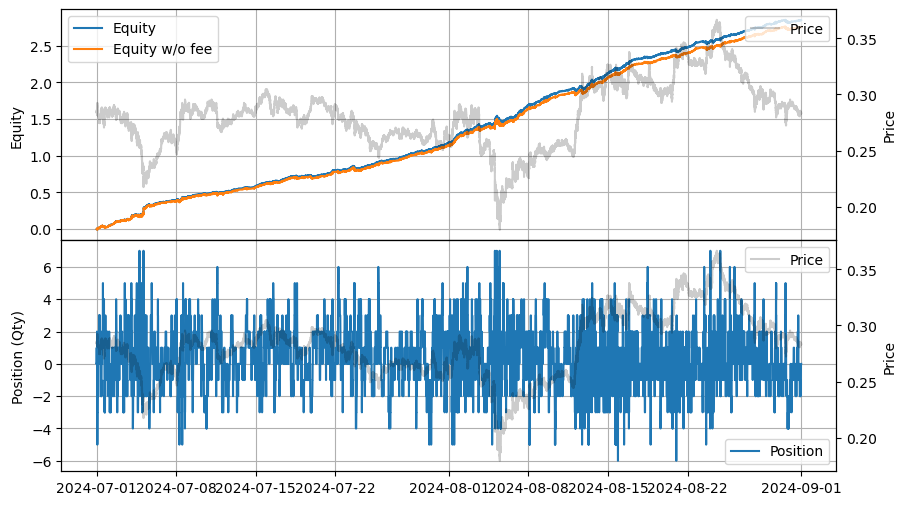

In [5]:
stats.plot()

## Trade Impulse

Let's examine how it changes when we incorporate the trade impulse.

In [6]:
from hftbacktest import BUY_EVENT

@njit
def mm_strategy(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    order_qty = 1
    grid_num = 10
    max_position = grid_num * order_qty
    # Our half spread is just half a tick size,
    # but it's considered a round-off error, so we use 0.49, which is slightly less than 0.5.
    half_spread = tick_size * 0.49
    grid_interval = tick_size
    skew_adj = 1.0
    trade_impulse_adj = 1.0

    sum_bbo_qty = np.empty(50_000_000, float64)
    i = 0
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:       
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        last_trades = hbt.last_trades(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        best_bid_qty = depth.bid_depth[depth.best_bid_tick]
        best_ask_qty = depth.ask_depth[depth.best_ask_tick]

        # Market microstructure signals in https://blog.headlandstech.com/2017/08/
        book_pressure = (best_bid * best_ask_qty + best_ask * best_bid_qty) / (best_bid_qty + best_ask_qty)
        
        # Computes the trade impulse
        last_qty = 0
        if len(last_trades) > 0:
            if last_trades[-1].ev & BUY_EVENT == BUY_EVENT:
                last_qty = last_trades[-1].qty
            else:
                last_qty = -last_trades[-1].qty

        hbt.clear_last_trades(asset_no)
        
        sum_bbo_qty[i] = best_bid_qty + best_ask_qty
        i += 1

        # Uses the last 1-minute average BBO quantity as the denominator.
        trade_impulse = (tick_size / 2.0) * last_qty / np.mean(sum_bbo_qty[max(0, i - 600):i])
        
        fair_price = book_pressure + trade_impulse * trade_impulse_adj
        
        skew = half_spread / grid_num * skew_adj

        normalized_position = position / order_qty

        # The personalized price that considers skewing based on inventory risk is introduced, 
        # which is described in the well-known Stokov-Avalleneda market-making paper.
        # https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf
        reservation_price = fair_price - skew * normalized_position

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(reservation_price - half_spread, best_bid)
        ask_price = np.maximum(reservation_price + half_spread, best_ask)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

In [7]:
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 100_000_000)

In [8]:
%%time
mm_strategy(hbt, recorder.recorder)

_ = hbt.close()

CPU times: user 8min 13s, sys: 8.03 s, total: 8min 21s
Wall time: 6min 48s


In [9]:
stats = LinearAssetRecord(recorder.get(0)).stats()
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-01 00:00:00,2024-08-31 23:59:50,16.52588,24.122559,2.874579,0.096359,106.580844,30.186685,29.831983,0.001536,2.4745


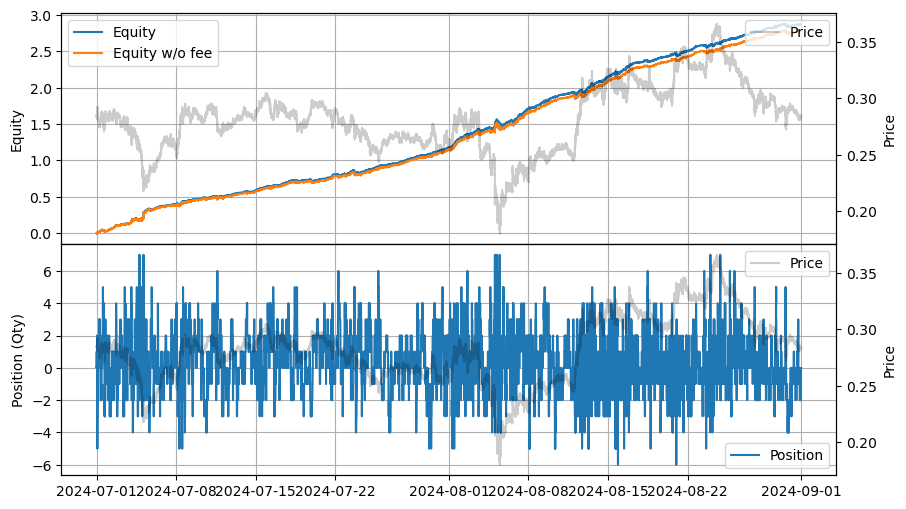

In [10]:
stats.plot()

There is not much difference, as the last trade quantity is relatively small compared to the best bid and offer quantities.

![CRVUSDT_depth](https://github.com/nkaz001/hftbacktest/blob/master/docs/images/CRVUSDT_depth.png)

The following example demonstrates a variant of trade impulse using aggregated trade quantities.

In [11]:
@njit
def mm_strategy(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    order_qty = 1
    grid_num = 10
    max_position = grid_num * order_qty
    # Our half spread is just half a tick size,
    # but it's considered a round-off error, so we use 0.49, which is slightly less than 0.5.
    half_spread = tick_size * 0.49
    grid_interval = tick_size
    skew_adj = 1.0
    trade_impulse_adj = 1.0

    sum_bbo_qty = np.empty(50_000_000, float64)
    i = 0
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:       
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        last_trades = hbt.last_trades(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        best_bid_qty = depth.bid_depth[depth.best_bid_tick]
        best_ask_qty = depth.ask_depth[depth.best_ask_tick]

        # Market microstructure signals in https://blog.headlandstech.com/2017/08/
        book_pressure = (best_bid * best_ask_qty + best_ask * best_bid_qty) / (best_bid_qty + best_ask_qty)
        
        # Computes the trading impulse
        last_qty = 0
        for last_trade in last_trades:
            if last_trade.ev & BUY_EVENT == BUY_EVENT:
                last_qty += last_trade.qty
            else:
                last_qty -= -last_trade.qty

        hbt.clear_last_trades(asset_no)
        
        sum_bbo_qty[i] = best_bid_qty + best_ask_qty
        i += 1

        # Uses the last 1-minute average BBO quantity as the denominator.
        trade_impulse = (tick_size / 2.0) * last_qty / np.mean(sum_bbo_qty[max(0, i - 600):i])
        
        fair_price = book_pressure + trade_impulse * trade_impulse_adj
        
        skew = half_spread / grid_num * skew_adj

        normalized_position = position / order_qty

        # The personalized price that considers skewing based on inventory risk is introduced, 
        # which is described in the well-known Stokov-Avalleneda market-making paper.
        # https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf
        reservation_price = fair_price - skew * normalized_position

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(reservation_price - half_spread, best_bid)
        ask_price = np.maximum(reservation_price + half_spread, best_ask)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

In [12]:
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 100_000_000)

In [13]:
%%time
mm_strategy(hbt, recorder.recorder)

_ = hbt.close()

CPU times: user 8min 13s, sys: 7.99 s, total: 8min 21s
Wall time: 6min 48s


In [14]:
stats = LinearAssetRecord(recorder.get(0)).stats()
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-01 00:00:00,2024-08-31 23:59:50,13.831429,20.083391,2.503742,0.114379,113.35505,32.174754,21.889804,0.001255,2.828


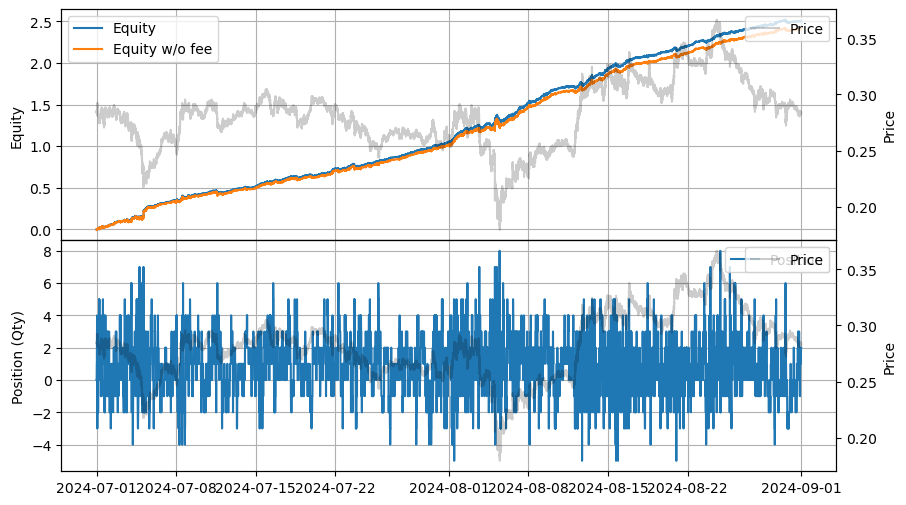

In [15]:
stats.plot()

You can also adjust `trade_impulse_adj` to modify the impact of the trade impulse. Alternatively, you can explore other ways to compute the trade impulse, such as `(best_bid * best_ask_qty + best_ask * best_bid_qty + last_px * last_qty) / (best_bid_qty + best_ask_qty + last_qty)`, VWAP, etc.

## Pure Queue-Based Model

One possible reason for this strategy's profitability is the limited price movement due to the large tick size. For instance, CRVUSDT has a tick size of 38 basis points (0.001 / 0.26 * 10,000), which is comparatively very larger than BTCUSDT, where the tick size is approximately 0.018 basis points (0.1 / 54,000 * 10,000).

This also highlights the importance of queue position modeling in fill simulations for assets with large tick sizes.

In the CRVUSDT charts shown above, observing the trading activities, you can see that most trades occur at the best bid and ask prices, with little change in the overall price level.

This suggests an opportunity to adjust the microstructure signal into a purely queue-based signal. For example, if there is sufficient quantity to maintain the price level, preventing it from moving adversely, we can choose to maintain our quote. Let’s explore how this can be implemented in a simplified form.

In [16]:
@njit
def mm_strategy(hbt, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    order_qty = 1
    grid_num = 10
    max_position = grid_num * order_qty
    # Our half spread is just half a tick size,
    # but it's considered a round-off error, so we use 0.49, which is slightly less than 0.5.
    half_spread = tick_size * 0.49
    grid_interval = tick_size
    skew_adj = 1.0
    qty_threshold = 250_000
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:       
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        last_trades = hbt.last_trades(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask

        best_bid_qty = depth.bid_depth[depth.best_bid_tick]
        best_ask_qty = depth.ask_depth[depth.best_ask_tick]
        
        skew = half_spread / grid_num * skew_adj

        normalized_position = position / order_qty

        skew_val = skew * normalized_position
        if best_bid_qty < qty_threshold and skew_val > 0:
            bid_price = best_bid - tick_size
        else:
            bid_price = best_bid
            
        if best_ask_qty < qty_threshold and skew_val < 0:
            ask_price = best_ask + tick_size
        else:
            ask_price = best_ask
        
        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

In [17]:
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 100_000_000)

In [18]:
%%time
mm_strategy(hbt, recorder.recorder)

_ = hbt.close()

CPU times: user 8min 16s, sys: 8.52 s, total: 8min 24s
Wall time: 6min 51s


In [19]:
stats = LinearAssetRecord(recorder.get(0)).stats()
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-01 00:00:00,2024-08-31 23:59:50,13.199337,18.042325,3.95075,0.18009,1840.60021,509.758968,21.937611,0.000125,3.6905


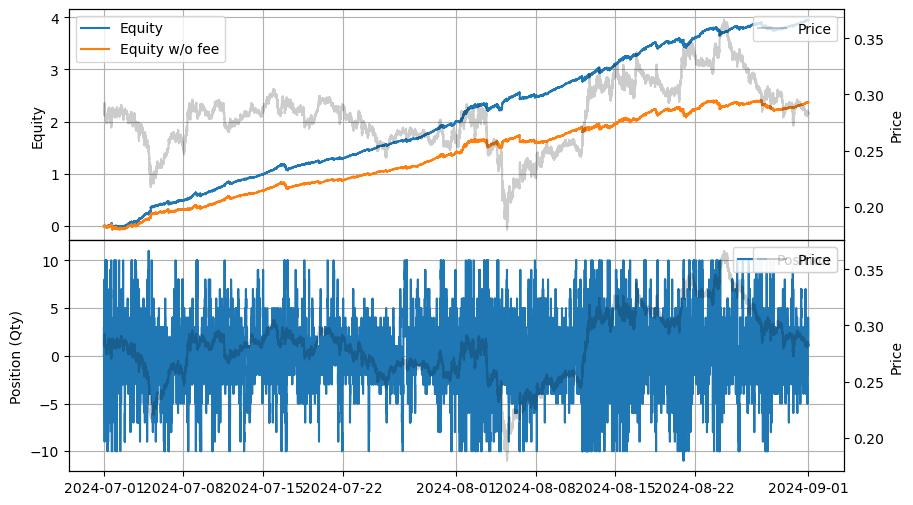

In [20]:
stats.plot()

You can also explore more sophisticated approaches, such as dynamically controlling the `qty_threshold` and integrating it with the skew value, for example, `qty_threshold * (1 ± skew_val)`, similar to how skew is applied to the price. In other words, in the previous example, the spread is set in terms of price, but you can set the spread in terms of queue such as the queue position, the queue behind the order, the total queue, etc.

Additionally, instead of reacting at fixed intervals, it may be more effective to respond to each incoming feed. This allows for faster reactions when the quantity at the BBO decreases rapidly, helping to avoid adverse selection. You can test this approach using the `wait_next_feed` method.